In [1]:
!pip install -q wordninja pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# Imports
!pip install -q transformers datasets evaluate scikit-learn pandas numpy matplotlib seaborn
!pip install -q tensorflow
!pip install -q tf-keras

import os
import re
import json
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
import wordninja
from datasets import Dataset
from datetime import datetime
import torch
from torch.nn import CrossEntropyLoss

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix, label_ranking_average_precision_score, accuracy_score, ConfusionMatrixDisplay
# Updated imports for DeBERTa
from transformers import DebertaV2TokenizerFast, DebertaV2Model, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
# from sklearn.utils.class_weight import compute_class_weight

warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.2 MB/s eta 0:00:00


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set output directory for results
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
output_dir = f"/content/drive/MyDrive/266_final_project_outputs/deberta_model_{timestamp}"
os.makedirs(output_dir, exist_ok=True)

In [5]:
# Load Data
data_dir = "drive/MyDrive/266_final_project/data"

# Load .tsv files
train_data = pd.read_csv("drive/MyDrive/266_final_project/data/train.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])
valid_data = pd.read_csv("drive/MyDrive/266_final_project/data/dev.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])
test_data = pd.read_csv("drive/MyDrive/266_final_project/data/test.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])

# Load emotions list
with open(f"{data_dir}/emotions.txt", "r") as f:
    emotion_list = f.read().splitlines()

In [6]:
df_full = pd.read_csv("drive/MyDrive/266_final_project/outputs/goemotions_primary_label.csv")
df_full.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,primary_label
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,1,0,0,24
1,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,1,26
2,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,0,0,0,0,0,0,0,0,0,17
3,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,1,26
4,Right? Considering it’s such an important docu...,eespn2i,ImperialBoss,TrueReddit,t3_aizyuz,t1_eesoak0,1.548280e+09,61,False,0,...,0,0,0,0,0,0,0,0,0,14


In [7]:
# Keep only ID, author, subreddit
full_meta = df_full[["id", "author", "subreddit"]].drop_duplicates()

In [8]:
def clean_subreddit_name(subreddit):
    subreddit = subreddit.replace("_", " ")
    words = []
    for word in subreddit.split():
        words += wordninja.split(word)
    return " ".join(words)

def clean_author_name(author):
    author = author.replace("_", " ")
    words = []
    for word in author.split():
        words += wordninja.split(word)
    return " ".join(words)

def build_input_with_context(row):
    author_clean = clean_author_name(row["author"])
    subreddit_clean = clean_subreddit_name(row["subreddit"])
    return f"{author_clean} on subreddit {subreddit_clean}: {row['Text']}"

def merge_and_add_context(split_df):
    merged = split_df.merge(full_meta, how="left", left_on="ID", right_on="id")
    merged = merged.dropna(subset=["author", "subreddit"])
    merged["text_with_context"] = merged.apply(build_input_with_context, axis=1)
    return merged

train_df = merge_and_add_context(train_data)
valid_df = merge_and_add_context(valid_data)
test_df  = merge_and_add_context(test_data)

train_df.head()

,Text,Class,ID,id,author,subreddit,text_with_context
0,My favourite food is anything I didn't have to...,27,eebbqej,eebbqej,Rockzilla78,KitchenConfidential,Rock zilla 78 on subreddit Kitchen Confidentia...
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,ed00q6i,cocaineluna,morbidquestions,cocaine luna on subreddit morbid questions: No...
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,eezlygj,minnesotagoat_,timberwolves,minnesota goat on subreddit timberwolves: WHY ...
3,To make her feel threatened,14,ed7ypvh,ed7ypvh,AlexNic1013,askwomenadvice,Alex Nic 1013 on subreddit ask women advice: T...
4,Dirty Southern Wankers,3,ed0bdzj,ed0bdzj,having_a_nap,london,having a nap on subreddit london: Dirty Southe...


In [9]:
# Parse labels into lists of emotion names
def decode_labels(label_str):
    return [emotion_list[int(i)] for i in label_str.split(',')]

train_df['decoded'] = train_df['Class'].apply(decode_labels)
valid_df['decoded'] = valid_df['Class'].apply(decode_labels)
test_df['decoded'] = test_df['Class'].apply(decode_labels)

In [10]:
# Filter out 'neutral' and 'disgust'
EXCLUDED_LABELS = {'neutral', 'disgust'}

def filter_labels(row):
    return [e for e in row if e not in EXCLUDED_LABELS]

def remove_rows(df):
    df = df.copy()
    df['filtered'] = df['decoded'].apply(filter_labels)
    return df[df['filtered'].map(len) > 0]

train_df = remove_rows(train_df)
valid_df = remove_rows(valid_df)
test_df = remove_rows(test_df)

In [11]:
# Create new emotion set
ekman_labels_3 = sorted(list(set([e for row in train_df['filtered'] for e in row])))
label_to_idx = {label: i for i, label in enumerate(ekman_labels_3)}

In [12]:
def get_primary_from_filtered(filtered):
    if isinstance(filtered, list) and filtered:
        return label_to_idx[filtered[0]]
    return -1

# Assign primary label from first valid emotion
train_df['primary'] = train_df['filtered'].apply(get_primary_from_filtered)
valid_df['primary'] = valid_df['filtered'].apply(get_primary_from_filtered)
test_df['primary']  = test_df['filtered'].apply(get_primary_from_filtered)

# Drop rows with no valid primary label
train_df = train_df[train_df['primary'] != -1]
valid_df = valid_df[valid_df['primary'] != -1]
test_df  = test_df[test_df['primary'] != -1]

### Tokenization:

In [13]:
# Updated for DeBERTa - using DeBERTa v2 base model
max_len = 256  # DeBERTa can handle longer sequences efficiently
tokenizer = DebertaV2TokenizerFast.from_pretrained("microsoft/deberta-v3-base")

def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=max_len)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

In [14]:
# Add special tokens before tokenizing or training
special_tokens = {'additional_special_tokens': ['[AUTHOR:', '[SUBREDDIT:']}
tokenizer.add_special_tokens(special_tokens)
print(tokenizer.additional_special_tokens)

['[AUTHOR:', '[SUBREDDIT:']


In [15]:
# Create Dataset from train_df
train_ds = Dataset.from_pandas(train_df[['text_with_context', 'primary']].copy())

# Rename columns
train_ds = train_ds.rename_column("text_with_context", "text")
train_ds = train_ds.rename_column("primary", "labels")

# Tokenize and format for model
train_ds = train_ds.map(tokenize, batched=True)
train_ds = train_ds.with_format("torch")

Map:   0%|          | 0/29542 [00:00<?, ? examples/s]

In [16]:
val_ds = Dataset.from_pandas(valid_df[['text_with_context', 'primary']].copy())
val_ds = val_ds.rename_column("text_with_context", "text")
val_ds = val_ds.rename_column("primary", "labels")
val_ds = val_ds.map(tokenize, batched=True)
val_ds = val_ds.with_format("torch")

Map:   0%|          | 0/3712 [00:00<?, ? examples/s]

In [17]:
test_ds = Dataset.from_pandas(test_df[['text_with_context', 'primary']].copy())
test_ds = test_ds.rename_column("text_with_context", "text")
test_ds = test_ds.rename_column("primary", "labels")
test_ds = test_ds.map(tokenize, batched=True)
test_ds = test_ds.with_format("torch")

Map:   0%|          | 0/3670 [00:00<?, ? examples/s]

In [18]:
# Load DeBERTa model for sequence classification
num_labels = len(label_to_idx)
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/deberta-v3-base",
    num_labels=num_labels
)

for param in model.parameters():
    param.requires_grad = True

# Resize token embeddings
model.resize_token_embeddings(len(tokenizer))

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(128003, 768, padding_idx=0)

In [19]:
# Updated training arguments for DeBERTa
training_args = TrainingArguments(
    output_dir="./checkpoints_deberta",
    run_name="deberta_no_weights_run",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs_deberta",
    num_train_epochs=6,
    per_device_train_batch_size=8,  # Reduced batch size due to DeBERTa's larger memory footprint
    per_device_eval_batch_size=8,
    learning_rate=2e-5,  # Slightly lower learning rate for DeBERTa
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,  # Add warmup for DeBERTa
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    logging_strategy="epoch",
    gradient_accumulation_steps=2,  # To simulate larger batch size
    fp16=True  # Enable mixed precision training for efficiency
)

In [20]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    callbacks=[]
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,2.155600,1.492067,0.576239
2,1.390900,1.368169,0.610453
3,1.140300,1.348813,0.615032
4,0.936200,1.413002,0.615302
5,0.771000,1.470760,0.611800
6,0.687500,1.489730,0.610183


TrainOutput(global_step=11082, training_loss=1.1802453862224498, metrics={'train_runtime': 4850.8593, 'train_samples_per_second': 36.54, 'train_steps_per_second': 2.285, 'total_flos': 2.3323923395702784e+16, 'train_loss': 1.1802453862224498, 'epoch': 6.0})

In [22]:
BEST_DIR = "/content/drive/MyDrive/266_final_project/best_deberta_model"

# Save to Drive
trainer.save_model(BEST_DIR)
tokenizer.save_pretrained(BEST_DIR)

('/content/drive/MyDrive/266_final_project/best_deberta_model/tokenizer_config.json',
 '/content/drive/MyDrive/266_final_project/best_deberta_model/special_tokens_map.json',
 '/content/drive/MyDrive/266_final_project/best_deberta_model/spm.model',
 '/content/drive/MyDrive/266_final_project/best_deberta_model/added_tokens.json',
 '/content/drive/MyDrive/266_final_project/best_deberta_model/tokenizer.json')

In [23]:
# Evaluate the model on validation or test set
eval_metrics = trainer.evaluate()

# Save metrics to Drive
with open(f"{BEST_DIR}/eval_metrics.json", "w") as f:
    json.dump(eval_metrics, f, indent=2)

In [24]:
# Get predictions on test set
preds = trainer.predict(test_ds)

y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

# Reverse label_to_idx to get string label names
idx_to_label = {v: k for k, v in label_to_idx.items()}
label_names = [idx_to_label[i] for i in range(len(idx_to_label))]

# Generate classification report
report = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)
df_report = pd.DataFrame(report).transpose().round(2)

# Save full classification report
df_report.to_csv(f"{BEST_DIR}/emotion_classification_report.csv")

df_emotions = df_report.loc[label_names][["precision", "recall", "f1-score"]]
df_report

,precision,recall,f1-score,support
admiration,0.67,0.76,0.71,430.0
amusement,0.82,0.88,0.85,252.0
anger,0.56,0.64,0.60,197.0
annoyance,0.40,0.38,0.39,286.0
approval,0.51,0.54,0.53,318.0
caring,0.45,0.55,0.50,114.0
confusion,0.52,0.48,0.50,139.0
curiosity,0.61,0.68,0.64,233.0
desire,0.76,0.43,0.55,74.0
disappointment,0.47,0.31,0.37,127.0


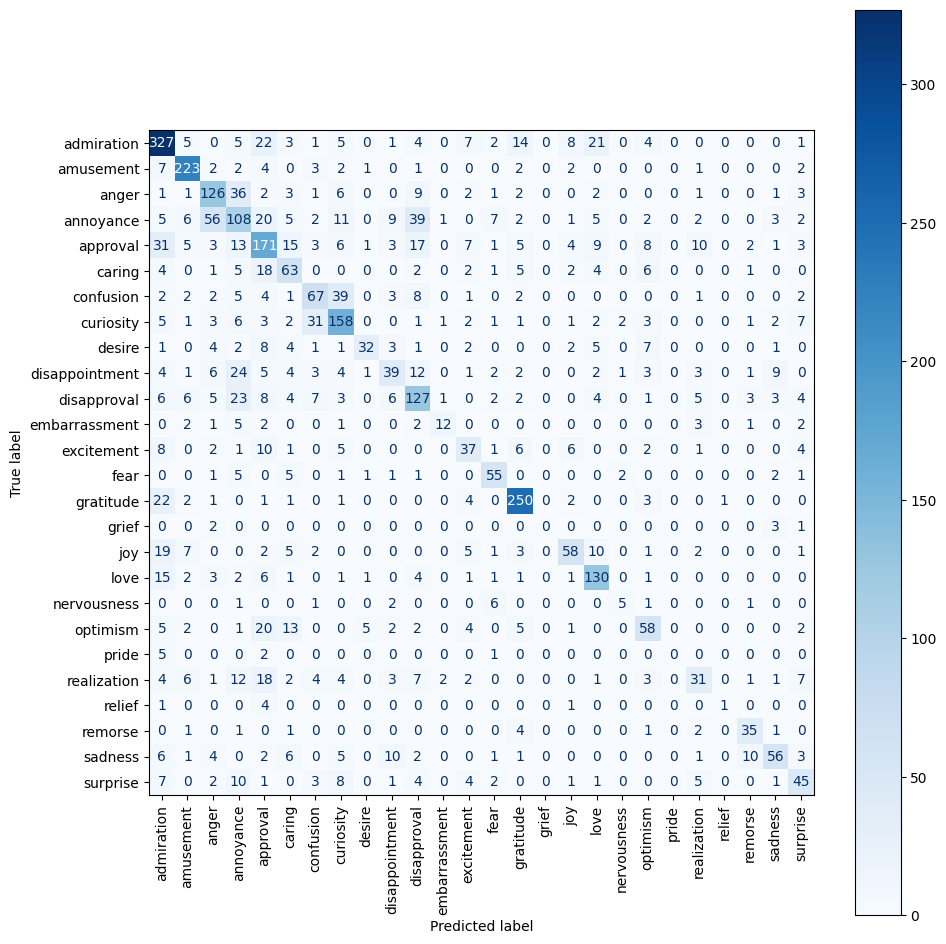

In [25]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Save matrix as image
disp = ConfusionMatrixDisplay(cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
plt.tight_layout()
plt.savefig(f"{BEST_DIR}/confusion_matrix.png")

# Save matrix as CSV
pd.DataFrame(cm, index=label_names, columns=label_names).to_csv(f"{BEST_DIR}/confusion_matrix.csv")

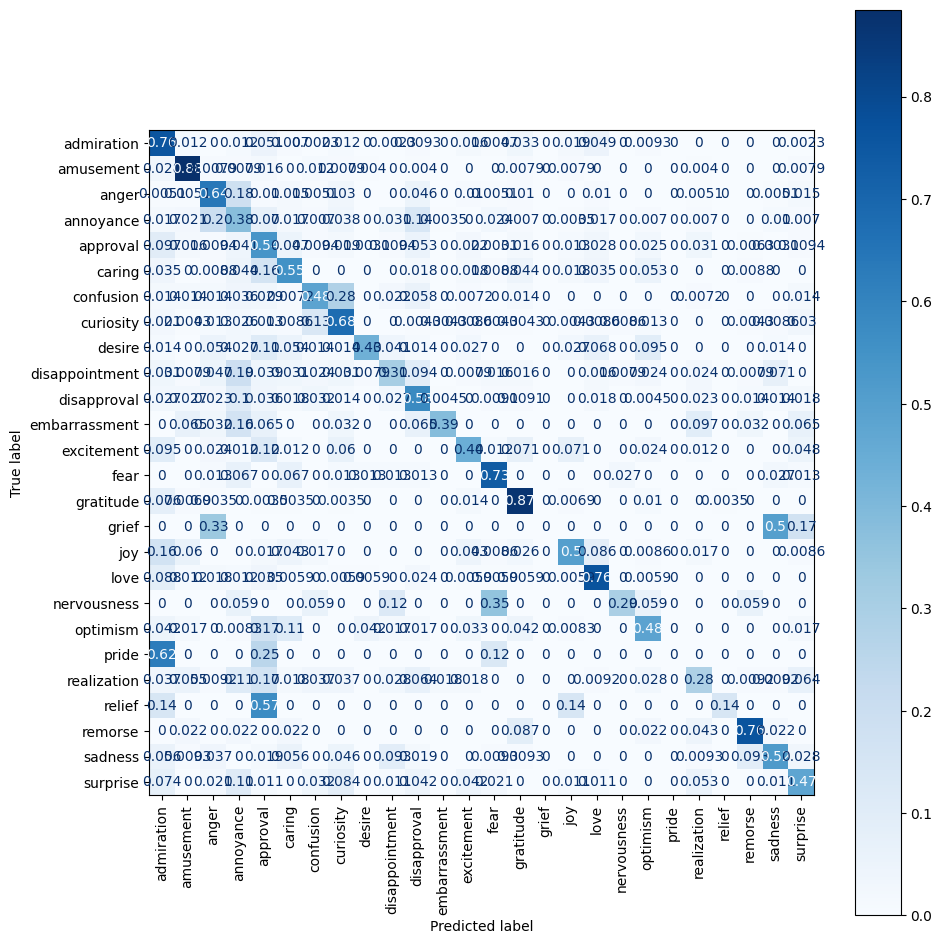

In [26]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Save matrix as image
disp = ConfusionMatrixDisplay(cm_normalized, display_labels=label_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues")
plt.tight_layout()
plt.savefig(f"{BEST_DIR}/confusion_matrix_normalized.png")

# Save matrix as CSV
pd.DataFrame(cm_normalized, index=label_names, columns=label_names).to_csv(f"{BEST_DIR}/confusion_matrix_normalized.csv")

In [27]:
df_report = df_report.rename_axis("Emotion").reset_index()
df_emotions = df_report[~df_report["Emotion"].str.contains("avg|accuracy|std", case=False, na=False)].copy()

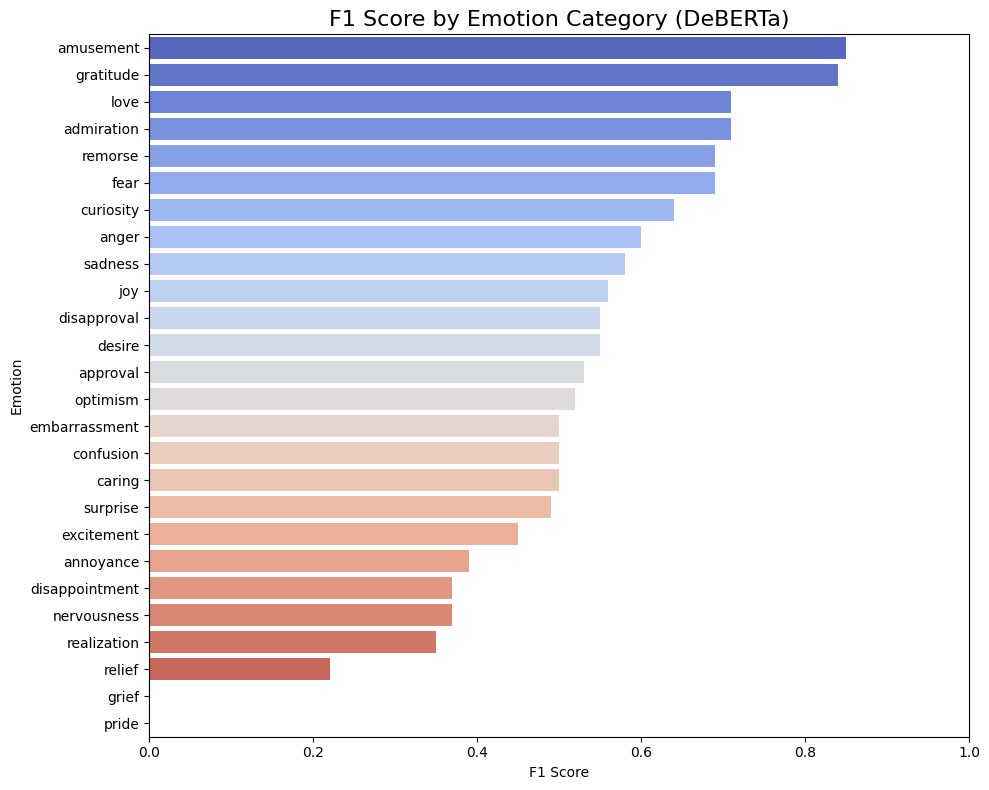

In [28]:
# Sort by F1
df_sorted = df_emotions.sort_values("f1-score", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=df_sorted, x="f1-score", y="Emotion", palette="coolwarm")
plt.title("F1 Score by Emotion Category (DeBERTa)", fontsize=16)
plt.xlabel("F1 Score")
plt.ylabel("Emotion")
plt.xlim(0, 1)
plt.tight_layout()

plt.savefig(f"{BEST_DIR}/emotion_f1_scores_paper_style.pdf")
plt.savefig(f"{BEST_DIR}/emotion_f1_scores_paper_style.png")
plt.show()

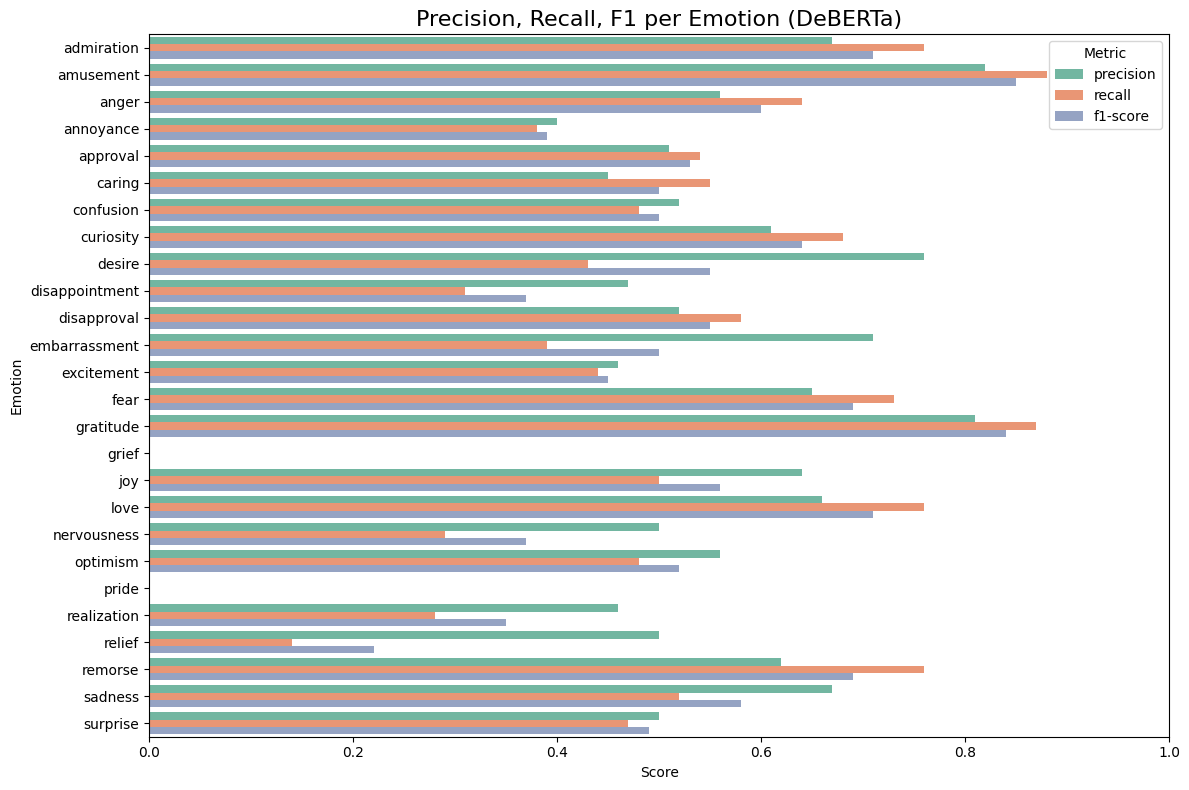

In [29]:
df_melted = df_emotions[["Emotion", "precision", "recall", "f1-score"]].melt(
    id_vars="Emotion", var_name="Metric", value_name="Score"
)

plt.figure(figsize=(12, 8))
sns.barplot(data=df_melted, x="Score", y="Emotion", hue="Metric", palette="Set2")
plt.title("Precision, Recall, F1 per Emotion (DeBERTa)", fontsize=16)
plt.xlabel("Score")
plt.ylabel("Emotion")
plt.xlim(0, 1)
plt.legend(title="Metric")
plt.tight_layout()

plt.savefig(f"{BEST_DIR}/figure_2_grouped_metrics_per_emotion.pdf")
plt.savefig(f"{BEST_DIR}/figure_2_grouped_metrics_per_emotion.png")
plt.show()

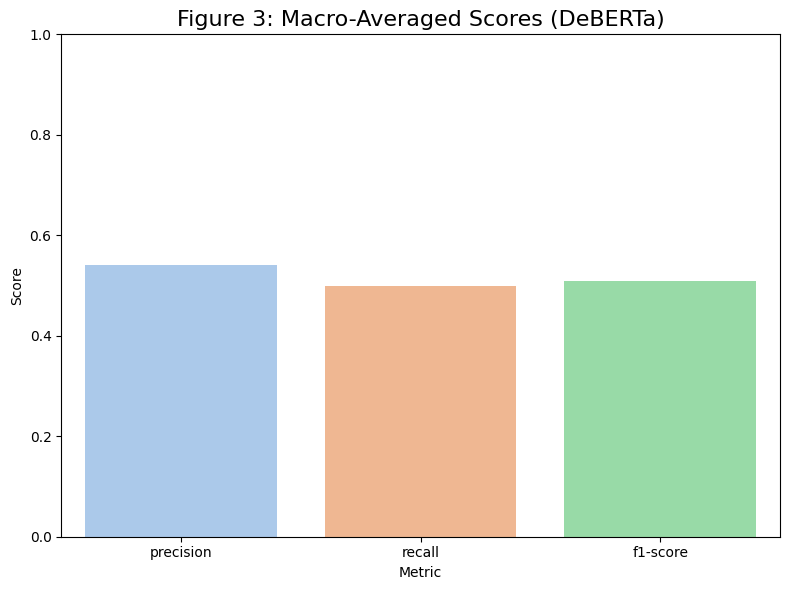

In [30]:
macro_avg = df_report[df_report["Emotion"] == "macro avg"]
macro_df = macro_avg[["precision", "recall", "f1-score"]].melt(
    var_name="Metric", value_name="Score"
)

plt.figure(figsize=(8, 6))
sns.barplot(data=macro_df, x="Metric", y="Score", palette="pastel")
plt.title("Figure 3: Macro-Averaged Scores (DeBERTa)", fontsize=16)
plt.ylim(0, 1)
plt.tight_layout()

plt.savefig(f"{BEST_DIR}/figure_3_macro_avg_scores.pdf")
plt.savefig(f"{BEST_DIR}/figure_3_macro_avg_scores.png")
macro_df.to_csv(f"{BEST_DIR}/figure_3_macro_avg_scores.csv", index=False)
plt.show()

In [31]:
df_support = df_emotions[["Emotion", "support"]].sort_values("support", ascending=False)
df_support.to_csv(f"{BEST_DIR}/emotion_support_counts.csv", index=False)

In [32]:
cm = confusion_matrix(y_true, y_pred)
conf_df = pd.DataFrame(cm, index=label_names, columns=label_names)
conf_df.to_csv(f"{BEST_DIR}/confusion_matrix_raw.csv")

# Top 10 most confused
np.fill_diagonal(cm, 0)
top_confused = sorted(
    [(label_names[i], label_names[j], cm[i, j])
     for i in range(len(cm)) for j in range(len(cm)) if cm[i, j] > 0],
    key=lambda x: -x[2]
)[:10]

print("Top 10 most confused pairs:")
for a, b, count in top_confused:
    print(f"{a} ↔ {b}: {count} times")

Top 10 most confused pairs:
annoyance ↔ anger: 56 times
annoyance ↔ disapproval: 39 times
confusion ↔ curiosity: 39 times
anger ↔ annoyance: 36 times
approval ↔ admiration: 31 times
curiosity ↔ confusion: 31 times
disappointment ↔ annoyance: 24 times
disapproval ↔ annoyance: 23 times
admiration ↔ approval: 22 times
gratitude ↔ admiration: 22 times
